## Lesson2 회귀분석

### 2.1. 선형회귀분석의 모수 추정 방법

In [57]:
# 준비작업
## 패키지 로딩
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import platform
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.datasets import load_diabetes
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table


## 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10

print(f"현재 폰트: {plt.rcParams['font.family']}")

## 랜덤 시드 설정
np.random.seed(42)

현재 폰트: ['AppleGothic']


In [58]:
## 데이터셋 로딩
diabetes = load_diabetes()

In [65]:
# 데이터 탐색 및 전처리
## 데이터셋 기본 정보
print(f"데이터 형태: {diabetes.data.shape}")
print(f"특성 개수: {len(diabetes.feature_names)}")
print(f"특성 이름: {diabetes.feature_names}")
print(f"타겟 변수: 당뇨병 진행 정도 (연속형)")
print(f"샘플 수: {diabetes.data.shape[0]}")

## 설명변수, 반응변수 세팅
X = diabetes.data # 설명변수
y = diabetes.target # 반응변수
feature_names = diabetes.feature_names

print(f"X 형태: {X.shape}")
print(f"y 형태: {y.shape}")

데이터 형태: (442, 10)
특성 개수: 10
특성 이름: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
타겟 변수: 당뇨병 진행 정도 (연속형)
샘플 수: 442
X 형태: (442, 10)
y 형태: (442,)


In [66]:
# 데이터 탐색 및 시각화
## 데이터프레임 생성
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

## 요약 통계량
print("=== 기본 통계 정보 ===")
print(df.describe())

=== 기본 통계 정보 ===
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02 

In [67]:
## 상관분석
correlation_matrix = df.corr()
print("타겟 변수와의 상관관계:")
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)

타겟 변수와의 상관관계:
target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64


시각화할 모든 특성들: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
타겟과의 상관관계:
  age: 0.1879
  sex: 0.0431
  bmi: 0.5865
  bp: 0.4415
  s1: 0.2120
  s2: 0.1741
  s3: -0.3948
  s4: 0.4305
  s5: 0.5659
  s6: 0.3825


<Figure size 1600x1400 with 0 Axes>

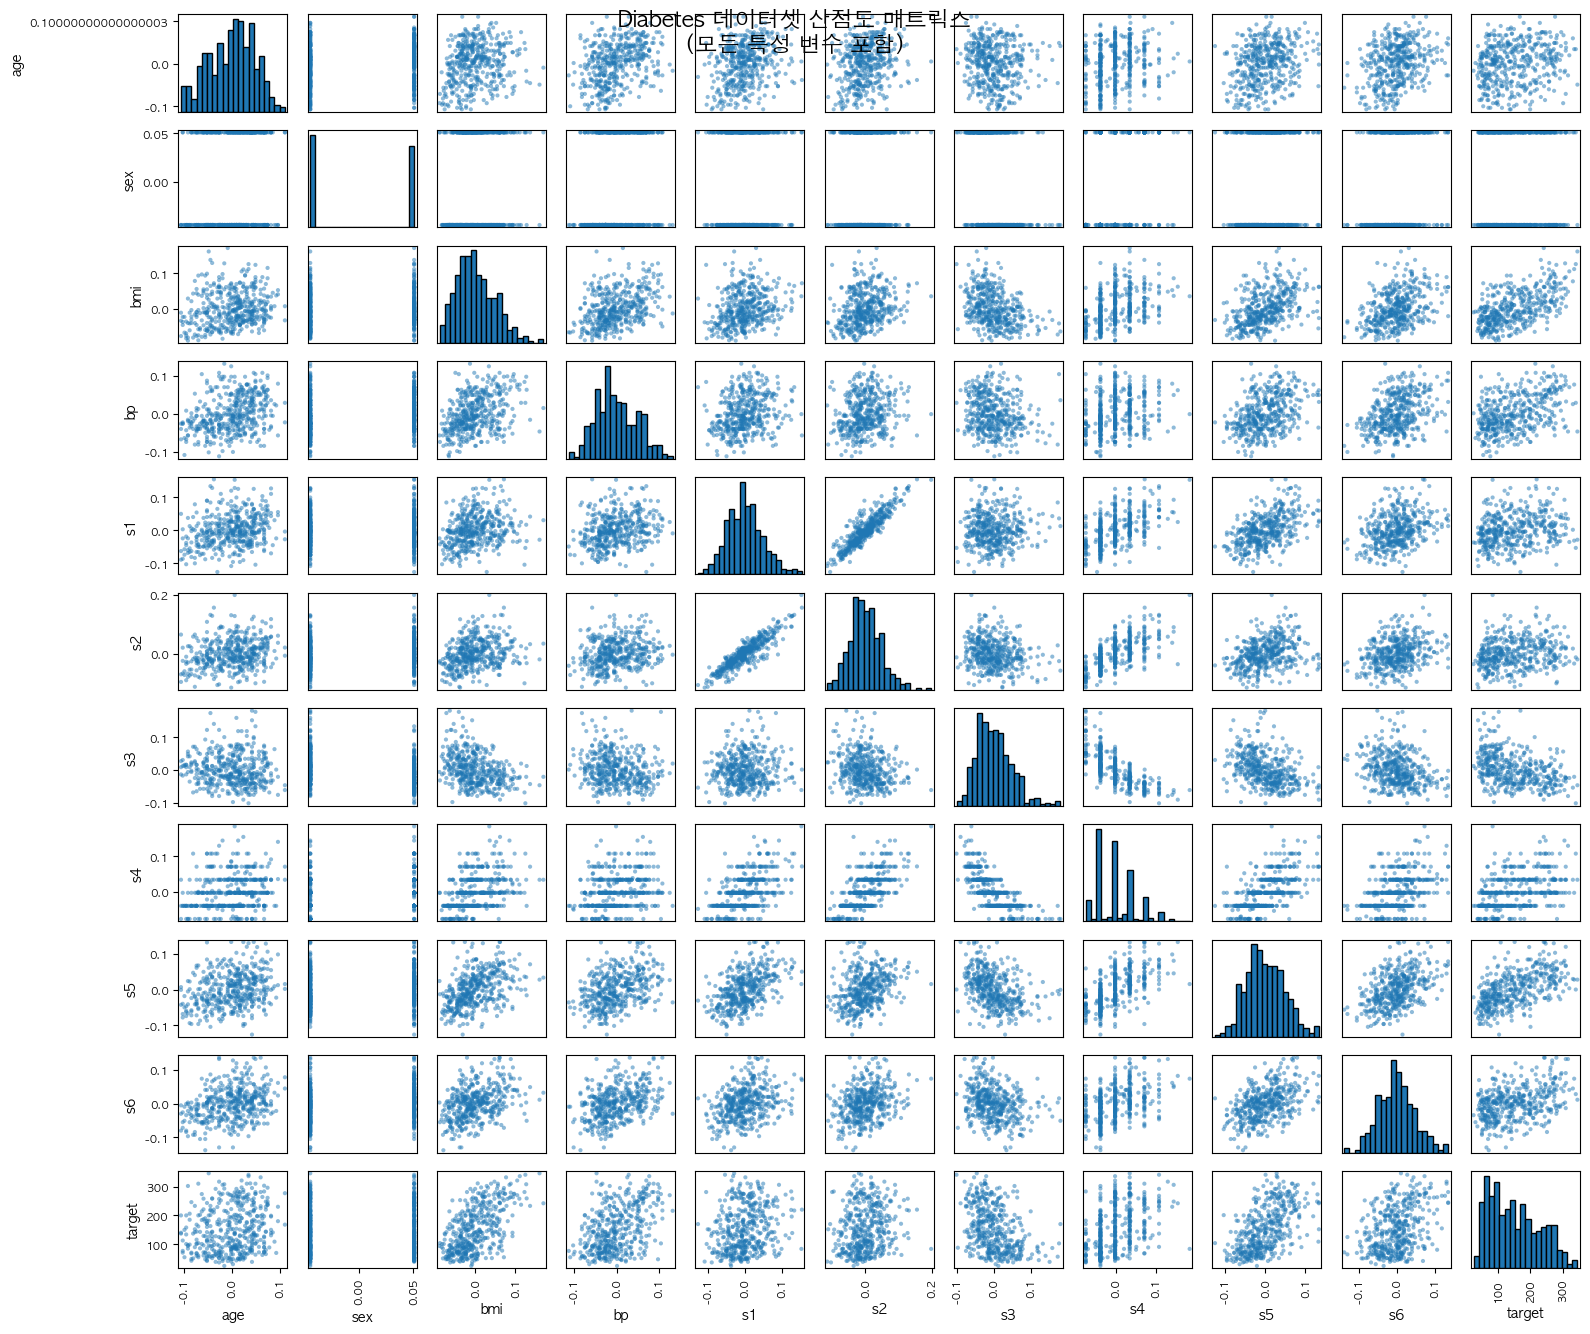

In [78]:
## 산점도 매트릭스 (모든 변수 사용)
### 모든 특성과 타겟 변수를 포함하여 산점도 매트릭스 생성
all_features = feature_names + ['target']

print(f"시각화할 모든 특성들: {feature_names}")
print(f"타겟과의 상관관계:")
for feature in feature_names:
    print(f"  {feature}: {target_corr[feature]:.4f}")

### 모든 변수를 포함한 산점도 매트릭스 생성
plt.figure(figsize=(16, 14))
pd.plotting.scatter_matrix(df[all_features], 
                          figsize=(16, 14), 
                          alpha=0.5, 
                          diagonal='hist',
                          hist_kwds={'bins': 20, 'edgecolor': 'black'})
plt.suptitle('Diabetes 데이터셋 산점도 매트릭스\n(모든 특성 변수 포함)', 
             fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

In [70]:
# 분석
## sklearn을 이용한 회귀분석
### 설명변수 세팅
X_sklearn = X

### 객체 생성 및 적합
model_sklearn = LinearRegression()
model_sklearn.fit(X_sklearn, y)

# 추정통계량 확인
beta0_sklearn = model_sklearn.intercept_  # 절편
betas_sklearn = model_sklearn.coef_       # 회귀계수

print(f"추정된 절편(β₀): {beta0_sklearn:.4f}")
print(f"추정된 회귀계수들:")
for i, (feature, coef) in enumerate(zip(feature_names, betas_sklearn)):
    print(f"  β_{i+1} ({feature}): {coef:.4f}")

추정된 절편(β₀): 152.1335
추정된 회귀계수들:
  β_1 (age): -10.0099
  β_2 (sex): -239.8156
  β_3 (bmi): 519.8459
  β_4 (bp): 324.3846
  β_5 (s1): -792.1756
  β_6 (s2): 476.7390
  β_7 (s3): 101.0433
  β_8 (s4): 177.0632
  β_9 (s5): 751.2737
  β_10 (s6): 67.6267


In [ ]:
## statsmodels를 이용한 회귀분석
### 설명변수 세팅
X_sm = sm.add_constant(X)  # 절편 계산을 위해 상수항 열 추가

### 객체 생성 및 적합
model_sm = sm.OLS(y, X_sm)
results_sm = model_sm.fit()

### 추정통계량 확인
beta0_sm = results_sm.params[0]  # 절편
betas_sm = results_sm.params[1:]  # 회귀계수

print(f"추정된 절편(β₀): {beta0_sm:.4f}")
print(f"추정된 회귀계수들:")
for i, (feature, coef) in enumerate(zip(feature_names, betas_sm)):
    print(f"  β_{i+1} ({feature}): {coef:.4f}")

### 회귀분석 결과 요약
print(results_sm.summary())

추정된 절편(β₀): 152.1335
추정된 회귀계수들:
  β_1 (age): -10.0099
  β_2 (sex): -239.8156
  β_3 (bmi): 519.8459
  β_4 (bp): 324.3846
  β_5 (s1): -792.1756
  β_6 (s2): 476.7390
  β_7 (s3): 101.0433
  β_8 (s4): 177.0632
  β_9 (s5): 751.2737
  β_10 (s6): 67.6267

STATSMODELS 회귀분석 결과 요약 리포트
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           3.83e-62
Time:                        10:23:29   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Typ

In [ ]:
## 행렬 계산을 이용한 회귀분석

In [72]:
# 설계행렬(design matrix) X 구성
X_matrix = np.column_stack([np.ones(n), X])  # [1, X1, X2, ..., X10] 형태로 구성
print("=== 설계행렬 X 정보 ===")
print(f"X_matrix 형태: {X_matrix.shape}")
print("X_matrix (첫 5행, 첫 6열):")
print(X_matrix[:5, :6])
print("특성 순서: [절편, " + ", ".join(feature_names) + "]")


# 정규방정식을 이용한 모수 추정
print(f"\n=== 정규방정식 계산: β = (X'X)^(-1)X'Y ===")

# 단계별 계산
XtX = X_matrix.T @ X_matrix  # X'X (11 x 11 행렬)
XtX_inv = np.linalg.inv(XtX)  # (X'X)^(-1)
XtY = X_matrix.T @ y  # X'Y (11 x 1 벡터)
beta_matrix = XtX_inv @ XtY  # 최종 모수 추정 (11 x 1 벡터)

print(f"X'X 형태: {XtX.shape}")
print("X'X (첫 6행, 첫 6열):")
print(XtX[:6, :6])

print(f"\n(X'X)^(-1) 형태: {XtX_inv.shape}")
print("(X'X)^(-1) (첫 6행, 첫 6열):")
print(XtX_inv[:6, :6])

print(f"\nX'Y 형태: {XtY.shape}")
print(f"X'Y = {XtY}")

print(f"\nβ 형태: {beta_matrix.shape}")
print(f"β = {beta_matrix}")

beta0_matrix = beta_matrix[0]  # 절편
betas_matrix = beta_matrix[1:]  # 각 특성의 회귀계수

print(f"\n=== 행렬 계산 결과 ===")
print(f"추정된 절편(β₀): {beta0_matrix:.4f}")
print(f"추정된 회귀계수들:")
for i, (feature, coef) in enumerate(zip(feature_names, betas_matrix)):
    print(f"  β_{i+1} ({feature}): {coef:.4f}")

=== 설계행렬 X 정보 ===
X_matrix 형태: (442, 11)
X_matrix (첫 5행, 첫 6열):
[[ 1.          0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235 ]
 [ 1.         -0.00188202 -0.04464164 -0.05147406 -0.02632753 -0.00844872]
 [ 1.          0.08529891  0.05068012  0.04445121 -0.00567042 -0.04559945]
 [ 1.         -0.08906294 -0.04464164 -0.01159501 -0.03665608  0.01219057]
 [ 1.          0.00538306 -0.04464164 -0.03638469  0.02187239  0.00393485]]
특성 순서: [절편, age, sex, bmi, bp, s1, s2, s3, s4, s5, s6]

=== 정규방정식 계산: β = (X'X)^(-1)X'Y ===
X'X 형태: (11, 11)
X'X (첫 6행, 첫 6열):
[[ 4.42000000e+02 -6.38378239e-16  1.12410081e-15 -9.97119054e-14
  -2.14550600e-14 -6.31439345e-15]
 [-6.38378239e-16  1.00000000e+00  1.73737101e-01  1.85084666e-01
   3.35427587e-01  2.60060820e-01]
 [ 1.12410081e-15  1.73737101e-01  1.00000000e+00  8.81613990e-02
   2.41010487e-01  3.52768192e-02]
 [-9.97119054e-14  1.85084666e-01  8.81613990e-02  1.00000000e+00
   3.95410899e-01  2.49777422e-01]
 [-2.14550600e-14  3.35427587

In [76]:
# 분석 결과

## 절편 비교
print("=== 절편(β₀) 비교 ===")
intercept_comparison = pd.DataFrame({
    'sklearn': [beta0_sklearn],
    'statsmodels': [beta0_sm],
    '행렬계산': [beta0_matrix]
}, index=['절편'])

print(intercept_comparison.round(4))

## 회귀계수 비교
print(f"\n=== 회귀계수들(β₁~β₁₀) 비교 ===")
coef_comparison = pd.DataFrame({
    'sklearn': betas_sklearn,
    'statsmodels': betas_sm,
    '행렬계산': betas_matrix
}, index=[f'{feature}' for feature in feature_names])

print(coef_comparison.round(4))

=== 절편(β₀) 비교 ===
     sklearn  statsmodels      행렬계산
절편  152.1335     152.1335  152.1335

=== 회귀계수들(β₁~β₁₀) 비교 ===
      sklearn  statsmodels      행렬계산
age  -10.0099     -10.0099  -10.0099
sex -239.8156    -239.8156 -239.8156
bmi  519.8459     519.8459  519.8459
bp   324.3846     324.3846  324.3846
s1  -792.1756    -792.1756 -792.1756
s2   476.7390     476.7390  476.7390
s3   101.0433     101.0433  101.0433
s4   177.0632     177.0632  177.0632
s5   751.2737     751.2737  751.2737
s6    67.6267      67.6267   67.6267


### 2.2. 관측치가 적을 때와 관측치가 많을 때에 추정통계량의 분산 차이

In [ ]:
# 준비작업
## 패키지 로딩
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import platform
import matplotlib.font_manager as fm

## 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'DejaVu Sans'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# 폰트 크기 설정
plt.rcParams['font.size'] = 10

print(f"현재 폰트: {plt.rcParams['font.family']}")

np.random.seed(42)

현재 폰트: ['AppleGothic']


시스템에서 발견된 한글 폰트:
  1. KoPubWorldBatang
  2. Nanum Myeongjo
  3. KHNPHandotum Bold
  4. NanumSquare
  5. Suseong Batang

선택된 폰트: AppleGothic


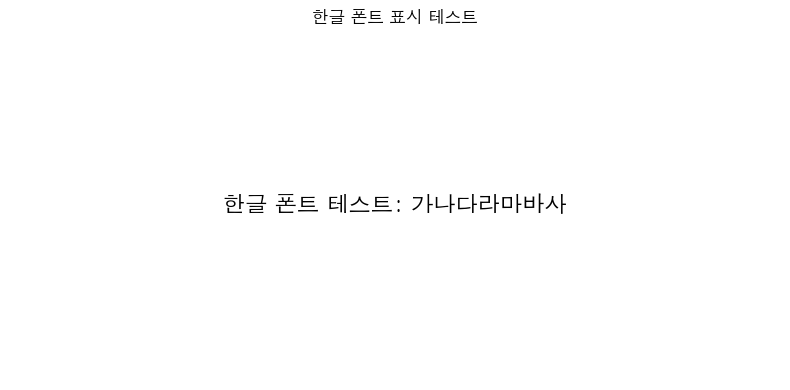

In [36]:
# 시스템에 설치된 한글 폰트 확인
korean_fonts = []
for font in fm.fontManager.ttflist:
    font_name = font.name
    # 한글 폰트 후보들
    korean_candidates = ['AppleGothic', 'Apple SD Gothic Neo', 'Nanum', 'Malgun Gothic', 
                        'Batang', 'Dotum', 'Gulim', 'Arial Unicode MS', 'NanumGothic']
    
    for candidate in korean_candidates:
        if candidate.lower() in font_name.lower():
            korean_fonts.append(font_name)
            break

if korean_fonts:
    print("시스템에서 발견된 한글 폰트:")
    unique_fonts = list(set(korean_fonts))[:5]  # 중복 제거하고 처음 5개만 표시
    for i, font in enumerate(unique_fonts):
        print(f"  {i+1}. {font}")
    
    # 가장 적합한 폰트 선택
    if 'AppleGothic' in korean_fonts:
        plt.rcParams['font.family'] = 'AppleGothic'
        selected_font = 'AppleGothic'
    elif any('Apple SD Gothic Neo' in font for font in korean_fonts):
        plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
        selected_font = 'Apple SD Gothic Neo'
    elif any('Nanum' in font for font in korean_fonts):
        nanum_font = next(font for font in korean_fonts if 'Nanum' in font)
        plt.rcParams['font.family'] = nanum_font
        selected_font = nanum_font
    else:
        plt.rcParams['font.family'] = korean_fonts[0]
        selected_font = korean_fonts[0]
    
    print(f"\n선택된 폰트: {selected_font}")
else:
    print("한글 폰트를 찾을 수 없습니다.")
    print("영문 폰트를 사용하거나 한글 폰트를 설치해주세요.")
    
# 한글 테스트
fig, ax = plt.subplots(figsize=(8, 4))
ax.text(0.5, 0.5, '한글 폰트 테스트: 가나다라마바사', 
        horizontalalignment='center', verticalalignment='center', 
        fontsize=16, transform=ax.transAxes)
ax.set_title('한글 폰트 표시 테스트')
ax.axis('off')
plt.tight_layout()
plt.show()

In [37]:
# 시뮬레이션 설정
num_experiments = 100  # 실험 횟수
sample_size_small = 1   # 작은 표본 크기
sample_size_large = 100 # 큰 표본 크기

# (1) 표본 크기 1로 100번 실험
estimates_n1 = []
for i in range(num_experiments):
    sample = np.random.normal(0, 1, sample_size_small)  # 표준정규분포에서 1개 추출
    sample_mean = np.mean(sample)  # 표본평균 (추정량)
    estimates_n1.append(sample_mean)

print(f"\n표본 크기 {sample_size_small}일 때:")
print(f"추정량의 평균: {np.mean(estimates_n1):.4f}")
print(f"추정량의 분산: {np.var(estimates_n1, ddof=1):.4f}")
print(f"추정량의 표준편차: {np.std(estimates_n1, ddof=1):.4f}")


표본 크기 1일 때:
추정량의 평균: -0.1038
추정량의 분산: 0.8248
추정량의 표준편차: 0.9082


In [38]:
# (2) 표본 크기 100으로 100번 실험
estimates_n100 = []
for i in range(num_experiments):
    sample = np.random.normal(0, 1, sample_size_large)  # 표준정규분포에서 100개 추출
    sample_mean = np.mean(sample)  # 표본평균 (추정량)
    estimates_n100.append(sample_mean)

print(f"\n표본 크기 {sample_size_large}일 때:")
print(f"추정량의 평균: {np.mean(estimates_n100):.4f}")
print(f"추정량의 분산: {np.var(estimates_n100, ddof=1):.4f}")
print(f"추정량의 표준편차: {np.std(estimates_n100, ddof=1):.4f}")


표본 크기 100일 때:
추정량의 평균: -0.0012
추정량의 분산: 0.0095
추정량의 표준편차: 0.0977


In [40]:
# 분산 비교 및 이론적 값과의 비교
print("분산 비교 결과:")
print(f"n=1일 때 추정량의 분산: {np.var(estimates_n1, ddof=1):.6f}")
print(f"n=100일 때 추정량의 분산: {np.var(estimates_n100, ddof=1):.6f}")
print(f"분산 비율 (n=1/n=100): {np.var(estimates_n1, ddof=1)/np.var(estimates_n100, ddof=1):.2f}")

분산 비교 결과:
n=1일 때 추정량의 분산: 0.824770
n=100일 때 추정량의 분산: 0.009548
분산 비율 (n=1/n=100): 86.38


/var/folders/nf/r8ssl6rn1mjgz9w_zq8xkp200000gn/T/ipykernel_52694/3406905871.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_for_boxplot, labels=['n=1', 'n=100'], patch_artist=True)


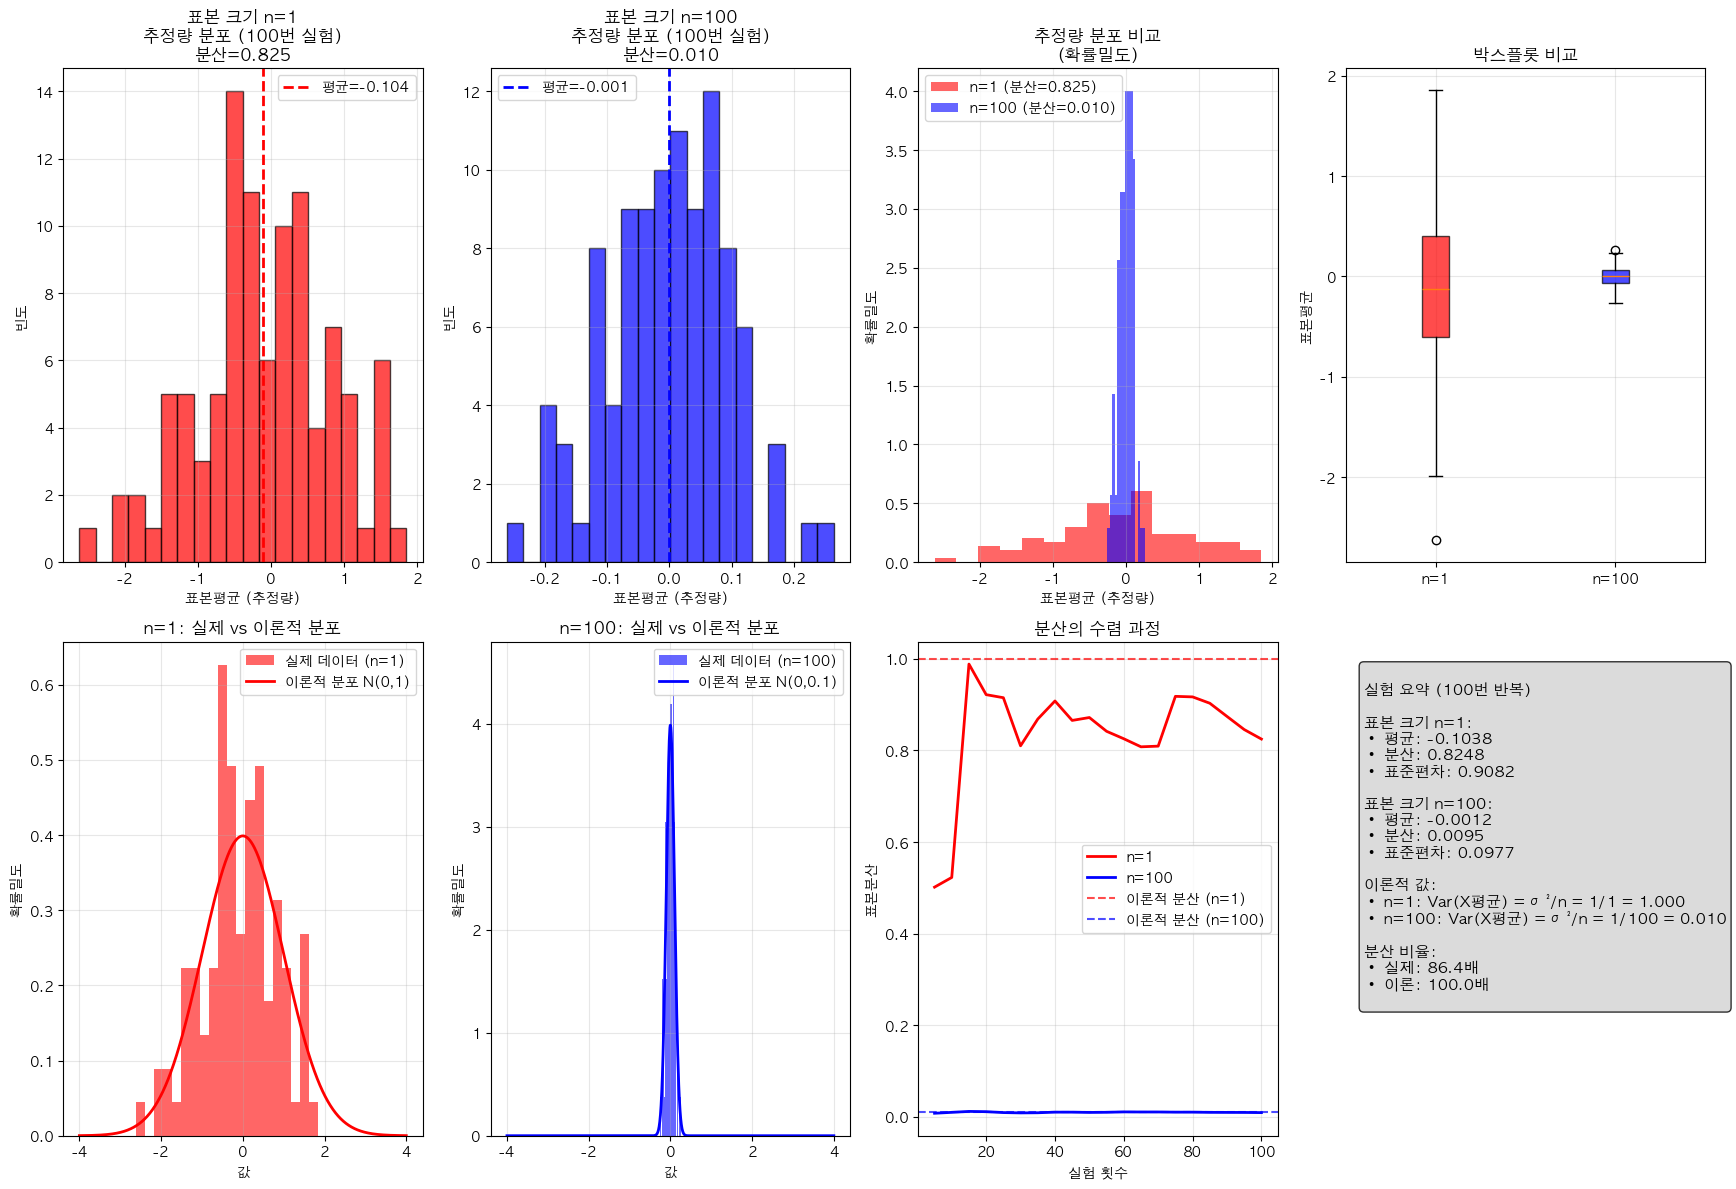

In [42]:
# 히스토그램으로 시각화
plt.figure(figsize=(18, 12))

# 1. 추정량 비교 히스토그램
plt.subplot(2, 4, 1)
plt.hist(estimates_n1, bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title(f'표본 크기 n=1\n추정량 분포 (100번 실험)\n분산={np.var(estimates_n1, ddof=1):.3f}')
plt.xlabel('표본평균 (추정량)')
plt.ylabel('빈도')
plt.axvline(np.mean(estimates_n1), color='red', linestyle='--', linewidth=2, label=f'평균={np.mean(estimates_n1):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 2)
plt.hist(estimates_n100, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'표본 크기 n=100\n추정량 분포 (100번 실험)\n분산={np.var(estimates_n100, ddof=1):.3f}')
plt.xlabel('표본평균 (추정량)')
plt.ylabel('빈도')
plt.axvline(np.mean(estimates_n100), color='blue', linestyle='--', linewidth=2, label=f'평균={np.mean(estimates_n100):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 두 분포를 겹쳐서 비교 (확률밀도)
plt.subplot(2, 4, 3)
plt.hist(estimates_n1, bins=15, alpha=0.6, color='red', label=f'n=1 (분산={np.var(estimates_n1, ddof=1):.3f})', density=True)
plt.hist(estimates_n100, bins=15, alpha=0.6, color='blue', label=f'n=100 (분산={np.var(estimates_n100, ddof=1):.3f})', density=True)
plt.title('추정량 분포 비교\n(확률밀도)')
plt.xlabel('표본평균 (추정량)')
plt.ylabel('확률밀도')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 박스플롯 비교
plt.subplot(2, 4, 4)
data_for_boxplot = [estimates_n1, estimates_n100]
bp = plt.boxplot(data_for_boxplot, labels=['n=1', 'n=100'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('blue')
bp['boxes'][1].set_alpha(0.7)
plt.title('박스플롯 비교')
plt.ylabel('표본평균')
plt.grid(True, alpha=0.3)

# 4. 이론적 분포와 비교
x = np.linspace(-4, 4, 1000)
theoretical_n1 = stats.norm.pdf(x, 0, 1)      # N(0, 1)
theoretical_n100 = stats.norm.pdf(x, 0, 0.1)  # N(0, 0.1)

plt.subplot(2, 4, 5)
plt.hist(estimates_n1, bins=20, alpha=0.6, color='red', density=True, label='실제 데이터 (n=1)')
plt.plot(x, theoretical_n1, 'red', linewidth=2, label='이론적 분포 N(0,1)')
plt.title('n=1: 실제 vs 이론적 분포')
plt.xlabel('값')
plt.ylabel('확률밀도')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 6)
plt.hist(estimates_n100, bins=20, alpha=0.6, color='blue', density=True, label='실제 데이터 (n=100)')
plt.plot(x, theoretical_n100, 'blue', linewidth=2, label='이론적 분포 N(0,0.1)')
plt.title('n=100: 실제 vs 이론적 분포')
plt.xlabel('값')
plt.ylabel('확률밀도')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. 분산의 수렴 과정
plt.subplot(2, 4, 7)
cumulative_vars_n1 = []
cumulative_vars_n100 = []
sample_sizes = range(5, 101, 5)  # 100번까지로 조정

for size in sample_sizes:
    cumulative_vars_n1.append(np.var(estimates_n1[:size], ddof=1))
    cumulative_vars_n100.append(np.var(estimates_n100[:size], ddof=1))

plt.plot(sample_sizes, cumulative_vars_n1, 'red', label='n=1', linewidth=2)
plt.plot(sample_sizes, cumulative_vars_n100, 'blue', label='n=100', linewidth=2)
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='이론적 분산 (n=1)')
plt.axhline(y=0.01, color='blue', linestyle='--', alpha=0.7, label='이론적 분산 (n=100)')
plt.title('분산의 수렴 과정')
plt.xlabel('실험 횟수')
plt.ylabel('표본분산')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. 요약 통계
plt.subplot(2, 4, 8)
plt.axis('off')
summary_text = f"""
실험 요약 (100번 반복)

표본 크기 n=1:
• 평균: {np.mean(estimates_n1):.4f}
• 분산: {np.var(estimates_n1, ddof=1):.4f}
• 표준편차: {np.std(estimates_n1, ddof=1):.4f}

표본 크기 n=100:
• 평균: {np.mean(estimates_n100):.4f}
• 분산: {np.var(estimates_n100, ddof=1):.4f}
• 표준편차: {np.std(estimates_n100, ddof=1):.4f}

이론적 값:
• n=1: Var(X평균) = σ²/n = 1/1 = 1.000
• n=100: Var(X평균) = σ²/n = 1/100 = 0.010

분산 비율:
• 실제: {np.var(estimates_n1, ddof=1)/np.var(estimates_n100, ddof=1):.1f}배
• 이론: 100.0배
"""

# 현재 설정된 한글 폰트를 사용하여 텍스트 표시
current_font = plt.rcParams['font.family']
if isinstance(current_font, list):
    current_font = current_font[0]

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top', 
         fontfamily=current_font,
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

### 2.3. 완전분리시 로지스틱 회귀모형 적합

In [1]:
# 준비작업
## 패키지 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import warnings

## 랜덤 시드 설정
np.random.seed(42)

In [17]:
## 데이터셋 생성
### 완전분리가 발생하는 인위적 데이터 생성 : X가 5보다 작으면 Y=0, X가 5보다 크면 Y=1로 완벽하게 분리
n_samples = 100

### 그룹1
X_group1 = np.random.uniform(0, 4.8, n_samples//2)
y_group1 = np.zeros(n_samples//2)

### 그룹2  
X_group2 = np.random.uniform(5.2, 10, n_samples//2)
y_group2 = np.ones(n_samples//2)

### 데이터 결합
X_complete_sep = np.concatenate([X_group1, X_group2])
y_complete_sep = np.concatenate([y_group1, y_group2])

df_complete_sep = pd.DataFrame({
    'X': X_complete_sep,
    'Y': y_complete_sep
})

## 요약통계량 계산
print(f"데이터 차원: {df_complete_sep.shape}")
print(df_complete_sep.groupby('Y')['X'].describe())

데이터 차원: (100, 2)
     count      mean       std       min       25%       50%       75%  \
Y                                                                        
0.0   50.0  2.295840  1.428189  0.033370  1.199591  2.026845  3.799881   
1.0   50.0  7.683345  1.393436  5.279622  6.361135  7.818341  8.815690   

          max  
Y              
0.0  4.664554  
1.0  9.931122  


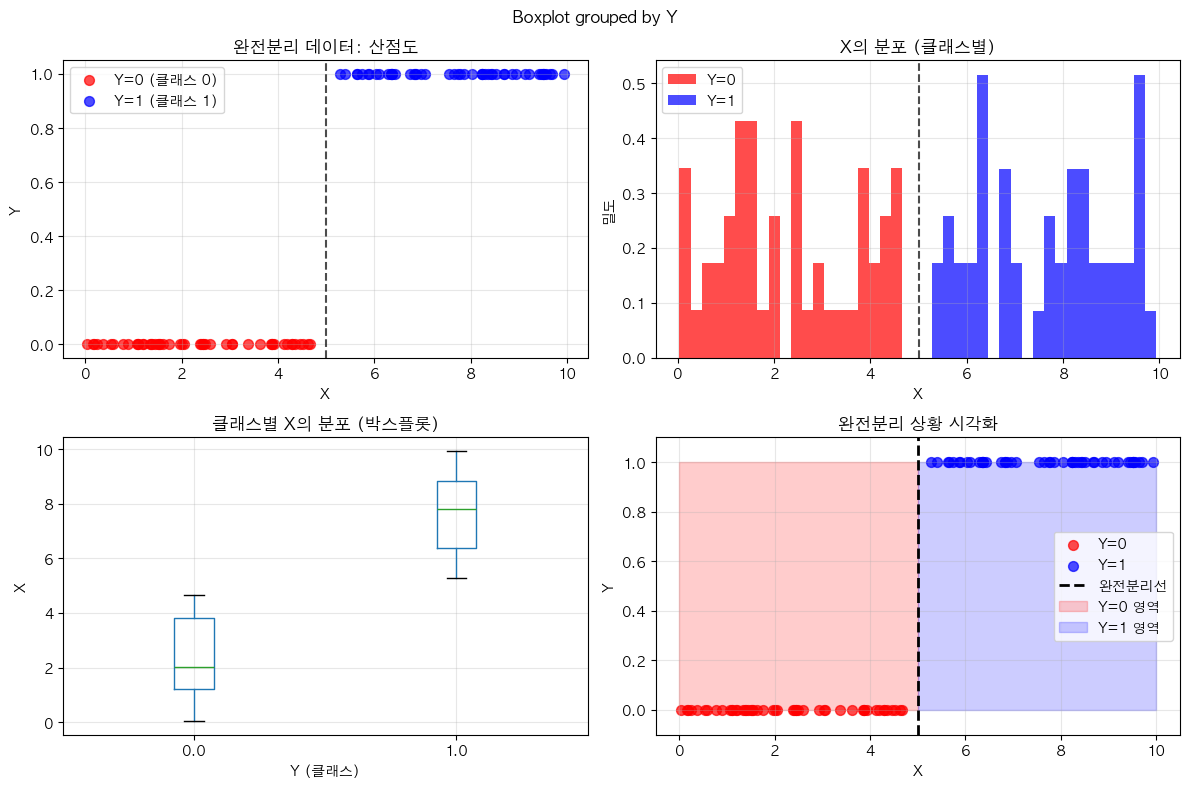

In [18]:
## 탐색적 분석
plt.figure(figsize=(12, 8))

### 산점도
plt.subplot(2, 2, 1)
colors = ['red', 'blue']
labels = ['Y=0 (클래스 0)', 'Y=1 (클래스 1)']

for i in range(2):
    mask = df_complete_sep['Y'] == i
    plt.scatter(df_complete_sep[mask]['X'], df_complete_sep[mask]['Y'], 
               c=colors[i], label=labels[i], alpha=0.7, s=50)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('완전분리 데이터: 산점도')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=5, color='black', linestyle='--', alpha=0.7, label='분리선 (X=5)')

### 히스토그램
plt.subplot(2, 2, 2)
plt.hist(df_complete_sep[df_complete_sep['Y']==0]['X'], 
         bins=20, alpha=0.7, color='red', label='Y=0', density=True)
plt.hist(df_complete_sep[df_complete_sep['Y']==1]['X'], 
         bins=20, alpha=0.7, color='blue', label='Y=1', density=True)
plt.xlabel('X')
plt.ylabel('밀도')
plt.title('X의 분포 (클래스별)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=5, color='black', linestyle='--', alpha=0.7)

### 박스플롯
plt.subplot(2, 2, 3)
df_complete_sep.boxplot(column='X', by='Y', ax=plt.gca())
plt.title('클래스별 X의 분포 (박스플롯)')
plt.xlabel('Y (클래스)')
plt.ylabel('X')
plt.grid(True, alpha=0.3)

### 분리 경계 표시
plt.subplot(2, 2, 4)
plt.scatter(df_complete_sep[df_complete_sep['Y']==0]['X'], 
           np.zeros(sum(df_complete_sep['Y']==0)), 
           c='red', label='Y=0', alpha=0.7, s=50)
plt.scatter(df_complete_sep[df_complete_sep['Y']==1]['X'], 
           np.ones(sum(df_complete_sep['Y']==1)), 
           c='blue', label='Y=1', alpha=0.7, s=50)
plt.axvline(x=5, color='black', linestyle='--', linewidth=2, label='완전분리선')
plt.fill_betweenx([0, 1], 0, 5, alpha=0.2, color='red', label='Y=0 영역')
plt.fill_betweenx([0, 1], 5, 10, alpha=0.2, color='blue', label='Y=1 영역')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('완전분리 상황 시각화')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

In [39]:
# 로지스틱 회귀 적합
## statsmodels 패키지

### 데이터 준비 (상수항 추가)
X_sm_logit = sm.add_constant(df_complete_sep['X'])
y_sm_logit = df_complete_sep['Y']

### 경고 메시지 표시 활성화
warnings.filterwarnings('default')

### 알고리즘 100회 반복
logit_model_sm_100 = sm.Logit(y_sm_logit, X_sm_logit)
results_logit_sm_100 = logit_model_sm_100.fit(maxiter=100, disp=True)
print(f"회귀계수 추정치 : {results_logit_sm_100.params[1]:.6f}")

### 알고리즘 1000회 반복
logit_model_sm_1000 = sm.Logit(y_sm_logit, X_sm_logit)
results_logit_sm_1000 = logit_model_sm_1000.fit(maxiter=1000, disp=True)
print(f"회귀계수 추정치 : {results_logit_sm_1000.params[1]:.6f}")

### 알고리즘 2000회 반복
logit_model_sm_2000 = sm.Logit(y_sm_logit, X_sm_logit)
results_logit_sm_2000 = logit_model_sm_2000.fit(maxiter=2000, disp=True)
print(f"회귀계수 추정치 : {results_logit_sm_2000.params[1]:.6f}")

         Current function value: 0.000000
         Iterations: 100
회귀계수 추정치 : 66.311049
         Current function value: 0.000000
         Iterations: 1000
회귀계수 추정치 : 56.185328
         Current function value: -0.000000
         Iterations: 2000
회귀계수 추정치 : 124.166267


/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nf/r8ssl6rn1mjgz9w_zq8xkp200000gn/T/ipykernel_450/3847405998.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"회귀계수 추정치 : {results_logit_sm_100.params[1]:.6f}")
/var/folders/nf/r8ssl6rn1mjgz9w_zq8xkp200000gn/T/ipykernel_450/3847405998.py:19: FutureWar

In [42]:
## 사이킷런

### 데이터 준비
X_sklearn_logit = df_complete_sep[['X']]
y_sklearn_logit = df_complete_sep['Y']

### 수렴임계치 조정
tolerances = [1e-2, 1e-4, 1e-6, 1e-8, 1e-10]

### 모형 적합
for tol in tolerances:
    print(f"\ntolerance = {tol:.0e}")
    
    logit_test = LogisticRegression(
        penalty=None,
        max_iter=50000,
        solver='newton-cg',
        tol=tol
    )
    
    logit_test.fit(X_sklearn_logit, y_sklearn_logit)
    
    intercept = logit_test.intercept_[0]
    coef = logit_test.coef_[0][0]
    n_iter = logit_test.n_iter_[0]
    
    print(f"반복횟수 : {n_iter}")
    print(f"절편 : {intercept:.2f}")
    print(f"회귀계수 추정치 : {coef:.2f}")


tolerance = 1e-02
반복횟수 : 7
절편 : -20.54
회귀계수 추정치 : 4.08

tolerance = 1e-04
반복횟수 : 12
절편 : -77.73
회귀계수 추정치 : 15.60

tolerance = 1e-06
반복횟수 : 17
절편 : -153.79
회귀계수 추정치 : 30.91

tolerance = 1e-08
반복횟수 : 22
절편 : -233.08
회귀계수 추정치 : 46.87

tolerance = 1e-10
반복횟수 : 26
절편 : -297.19
회귀계수 추정치 : 59.76
